# TNC/TAXI Fare Outliers

### Set-Up

In [1]:
# modules
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# import data
data_path = '../../data/processed/data_model_output_full_pii_taz.csv'
geography_path = '../../data/geographies/TAZ15.shp'

# output data
taxi_tnc_fare_outliers_path = '../../data/processed/taxi_tnc_fare_outliers.csv'

In [3]:
# take non-synthetic departing pax
survey_data = pd.read_csv(data_path).query('weight_departing_only > 0')
geographies = gpd.read_file(geography_path).query('~TAZ.isin([3,11])')

C:\Users\mwe\AppData\Local\Temp\ipykernel_21892\2288861360.py:2: DtypeWarning: Columns (16,21,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,48,49,55,56,59,60,61,81,83,84,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,133,135,143,151,152,153,158,163,168,170,176,178,184,193,194,195,202,213,215,216,219,220,236,244,280,281,282,285,288,289,292,293,294,296,297,316,332,334,335,337,349,374,378,386,392,409,430) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_data = pd.read_csv(data_path).query('weight_departing_only > 0')


# Visualize Outliers

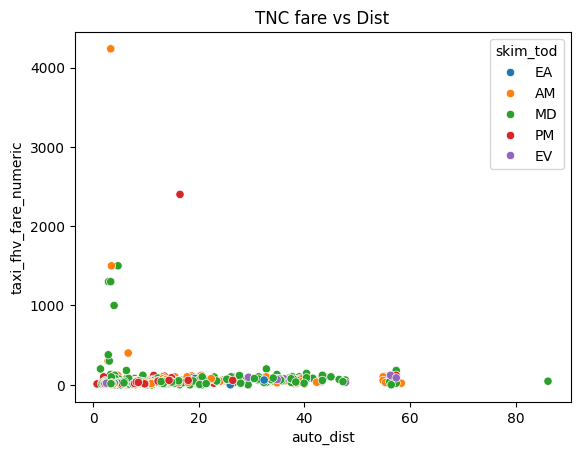

In [4]:
# scatterplot - cost vs distance colored by skim_tod
sns.scatterplot(
    data = (
            survey_data
            # .query('main_mode_label=="UBER_LYFT"')
            # .query('taxi_fhv_fare_numeric < 1000')
    ),
    x = 'auto_dist',
    y = 'taxi_fhv_fare_numeric',
    hue = 'skim_tod'
)
plt.title('TNC fare vs Dist')
plt.show()

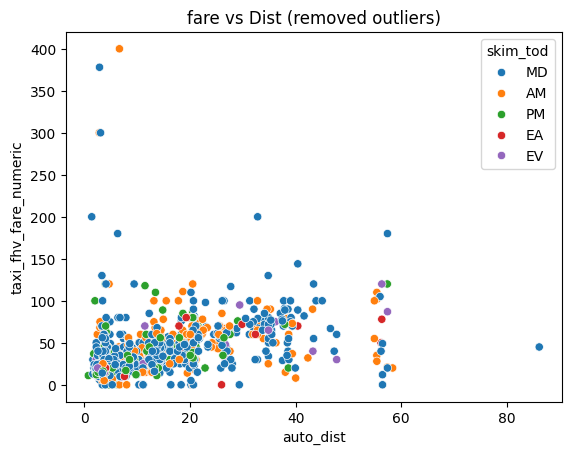

In [5]:
# scatterplot - cost vs distance colored by skim_tod
sns.scatterplot(
    data = (
            survey_data
            .query('taxi_fhv_fare_numeric < 1000')
    ),
    x = 'auto_dist',
    y = 'taxi_fhv_fare_numeric',
    hue = 'skim_tod'
)
plt.title('fare vs Dist (removed outliers)')
plt.show()

# Get Outlier Data
Outliers that raise most concern pay inordinate amounts and drive short distances. Respondents that reported >$1000 fares particularly merit investigation.

In [6]:
(survey_data
    .query('main_mode_label=="CAR_SERVICE_BLACK_LIMO"')
    ['weight_departing_only']
    .sum()
    .round(1)
)

np.float64(0.0)

In [7]:
outliers = (
    survey_data
    .query('taxi_fhv_fare_numeric > 150')
    .query('auto_dist < 30') # some long trips have cost greater than $150
    .query('main_mode_label!="CAR_SERVICE_BLACK_LIMO"')
)
print(f'Number of respondents that merit investigation: {outliers.shape[0]}')

Number of respondents that merit investigation: 13


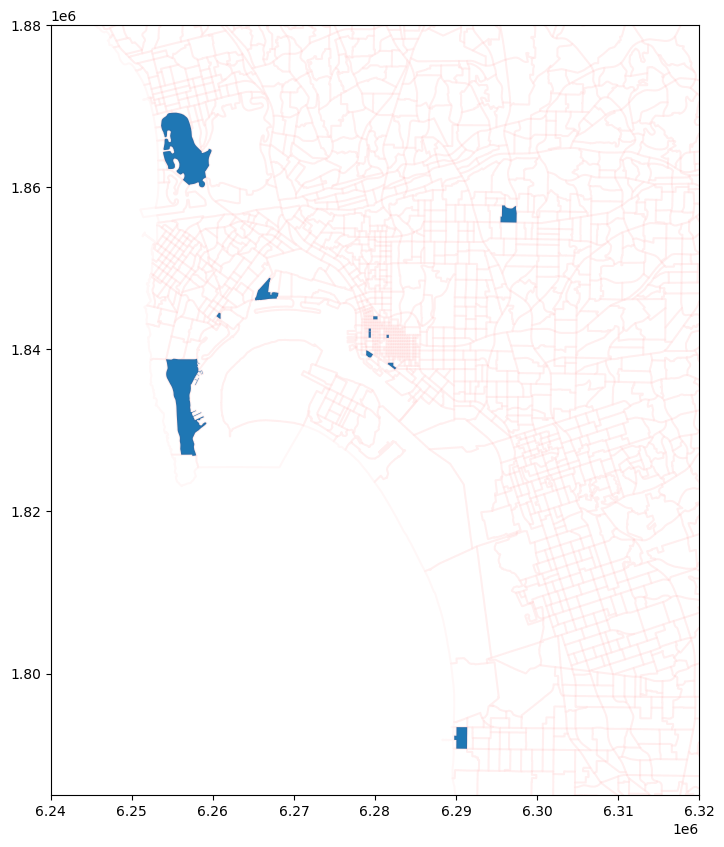

In [8]:
# origins of outliers
    # when we map destinations, only get airport (as expected)
_, ax = plt.subplots(figsize=(10, 10))

geographies.boundary.plot(ax = ax, color = 'red', alpha = .03)

geographies_survey_weights = (
                    geographies.merge(
                        outliers.groupby(f'origin_taz')['unique_id'].count().rename('count').reset_index(),
                        left_on="TAZ",
                        right_on=f'origin_taz'
                  )
)

geographies_survey_weights.to_crs(geographies.crs).plot(ax = ax, alpha = 1)#, column='count', legend=True)
plt.xlim((6.24e6,6.32e6))
plt.ylim((1.785e6,1.88e6))
plt.show()

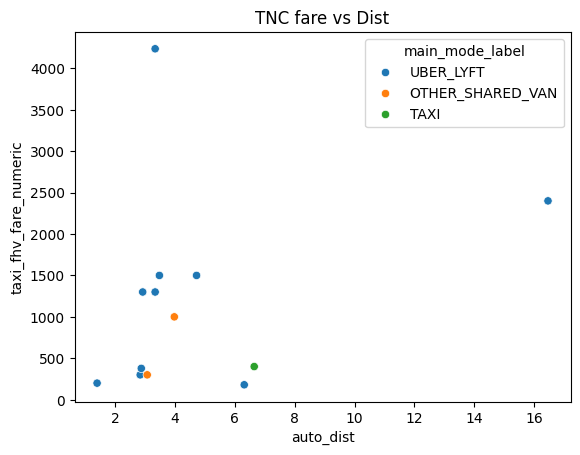

In [9]:
# scatterplot - cost vs distance colored by skim_tod
sns.scatterplot(
    data = (
            outliers
    ),
    x = 'auto_dist',
    y = 'taxi_fhv_fare_numeric',
    hue = 'main_mode_label'
)
plt.title('TNC fare vs Dist')
plt.show()

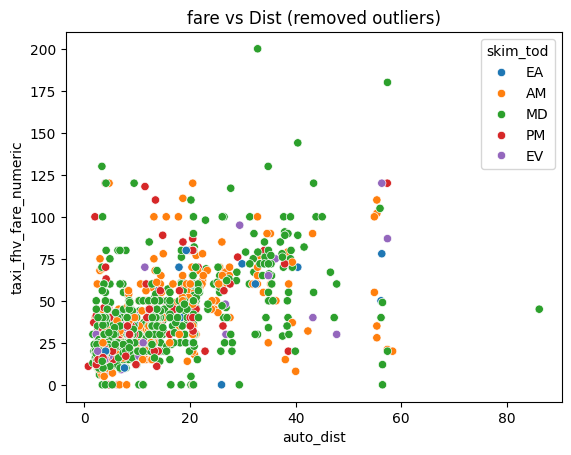

In [10]:
# scatterplot - cost vs distance colored by skim_tod
sns.scatterplot(
    data = (
            survey_data
            .loc[~survey_data.index.isin(outliers.index)]
            # .query('taxi_fhv_fare_numeric 0')
            .query('main_mode_label!="CAR_SERVICE_BLACK_LIMO"')
    ),
    x = 'auto_dist',
    y = 'taxi_fhv_fare_numeric',
    hue = 'skim_tod'
)
plt.title('fare vs Dist (removed outliers)')
plt.show()

### Implausibly Low Fares
After working w/ data, found that respondents reported implausibly low fares.

much more common than implausibly high fares

these fares are not necessarily impossibly - they could be reimbursed or taking advantage of some deal. Reimbursed fares should be covered elsewhere, and given the deals that TNCs send out occassionally, we should be very forgiving in curtailing values. The effect of these implausible fares on the resulting model should be mitigated in some way, tho.

In [11]:
min_cost_per_mile = .5 # dollars per mile
survey_data['fare_cost_per_mile'] = survey_data['taxi_fhv_fare_numeric'] / survey_data['auto_dist']

underreporting_outliers = (
    survey_data
    .query('main_mode_label.isin(["UBER_LYFT", "TAXI"])')
    .query(f'fare_cost_per_mile < {min_cost_per_mile}')
    ['unique_id']
)
underreporting_outliers.shape

(19,)

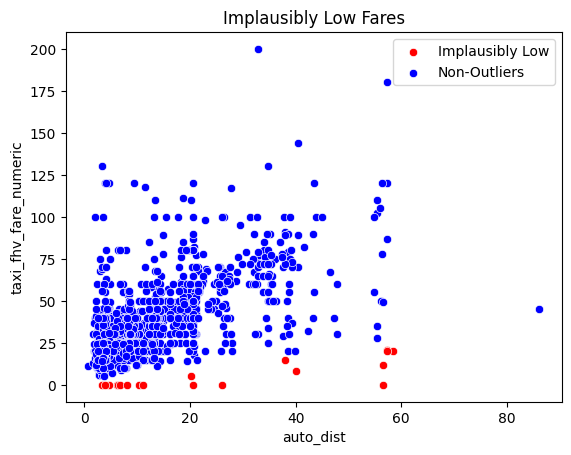

In [12]:
# scatterplot - cost vs distance colored by skim_tod
sns.scatterplot(
    data = (
            survey_data.query(f'unique_id.isin({underreporting_outliers.tolist()})')
    ),
    x = 'auto_dist',
    y = 'taxi_fhv_fare_numeric',
    color = 'red',
    label = 'Implausibly Low'
)
sns.scatterplot(
    data = (
            survey_data
            .query(f'~unique_id.isin({underreporting_outliers.tolist()})')
            .query(f'~unique_id.isin({outliers['unique_id'].tolist()})')
            .query('main_mode_label.isin(["UBER_LYFT", "TAXI"])')
    ),
    x = 'auto_dist',
    y = 'taxi_fhv_fare_numeric',
    color = 'blue',
    label = 'Non-Outliers'
)
plt.title('Implausibly Low Fares')
plt.show()

## Write Out Data

In [17]:
(
    pd.DataFrame(
        outliers['unique_id'].tolist() + underreporting_outliers.tolist(),
        columns=['unique_id']
    )
    .to_csv(taxi_tnc_fare_outliers_path)
)